In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import itertools
import pprint

import orbax.checkpoint
import jax
import jax.numpy as jnp
import torch.utils.data.dataloader
import tensorflow as tf
import sqlalchemy as sa
import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd
import matplotlib.pyplot as plt

from userdiffusion import samplers, unet
from userfm import cs, datasets, diffusion, sde_diffusion, flow_matching, utils, main as main_module

2025-01-13 02:29:55.893417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736735395.911740   38565 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736735395.917235   38565 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/root/workspace/GitHub/pmlr-v202-finzi23a/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# somehow, this line of code prevents a segmentation fault in nn.Dense
# when calling model.init
tf.config.experimental.set_visible_devices([], 'GPU')

In [4]:
engine = cs.get_engine()
cs.create_all(engine)
session = cs.orm.Session(engine)
session.begin()

In [77]:
config_alt_ids = {
    # Lorenz
    'rnb66blc': 'VE-SDE',
    '11a9cp2x': 'Flow Matching',
}

In [78]:
cfgs = session.execute(sa.select(cs.Config).where(cs.Config.alt_id.in_(config_alt_ids)))
cfgs = [c for (c,) in cfgs]
reference_cfg = cfgs[0]

In [26]:
key = jax.random.key(reference_cfg.rng_seed)

In [27]:
key, key_dataset = jax.random.split(key)
ds = datasets.get_dataset(reference_cfg.dataset, key=key_dataset)
splits = datasets.split_dataset(reference_cfg.dataset, ds)
dataloaders = {}
for n, s in splits.items():
    dataloaders[n] = torch.utils.data.dataloader.DataLoader(
        list(tf.data.Dataset.from_tensor_slices(s).batch(reference_cfg.dataset.batch_size).as_numpy_iterator()),
        batch_size=1,
        collate_fn=lambda x: x[0],
    )
data_std = splits['train'].std()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:40<00:00, 12.38it/s]


In [28]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
x_sample = next(iter(dataloaders['train']))

cfg_info = {}
for cfg in cfgs:
    assert cfg.rng_seed == reference_cfg.rng_seed
    assert cfg.dataset == reference_cfg.dataset

    cfg_unet = unet.unet_64_config(
        splits['train'].shape[-1],
        base_channels=cfg.model.architecture.base_channel_count,
        attention=cfg.model.architecture.attention,
    )
    model = unet.UNet(cfg_unet)
    # just create params, restore saved weights later
    params = model.init(
        jax.random.key(0),
        x=jnp.ones(x_sample.shape),
        t=jnp.ones(x_sample.shape[0]),
        train=False,
        cond=main_module.condition_on_initial_time_steps(x_sample, cfg.dataset.time_step_count_conditioning),
    )
    ema_params = orbax_checkpointer.restore(cfg.run_dir/'last_ema')

    if isinstance(cfg.model, cs.ModelDiffusion):
        jax_lightning = diffusion.JaxLightning(cfg, jax.random.key(0), dataloaders, data_std, None, model)
    elif isinstance(cfg.model, cs.ModelFlowMatching):
        jax_lightning = flow_matching.JaxLightning(cfg, jax.random.key(0), dataloaders, data_std, None, model)
    else:
        raise ValueError(f'Unknown model: {cfg.model}')

    cfg_info[cfg.alt_id] = dict(
        cfg=cfg,
        jax_lightning=jax_lightning,
        ema_params=ema_params,
    )

/root/workspace/GitHub/pmlr-v202-finzi23a/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [29]:
def constraint(x):
    fourier_magnitudes = jnp.abs(jnp.fft.rfft(x[..., 0], axis=-1))
    return -(fourier_magnitudes[..., 1:].mean(-1) - .6)

In [30]:
cond = None
trajectory_count = reference_cfg.dataset.batch_size
for config_alt_id, info in cfg_info.items():
    cfg = info['cfg']
    key, key_samples = jax.random.split(key)
    if isinstance(cfg.model, cs.ModelDiffusion):
        def score(x, t):
            if not hasattr(t, 'shape') or not t.shape:
                t = jnp.ones(x.shape[0]) * t
            return info['jax_lightning'].score(x, t, cond, info['ema_params'])
            
        samples = samplers.sde_sample(info['jax_lightning'].diffusion, score, key_samples, x_shape=x_sample.shape, nsteps=cfg.model.sde_time_steps)
        info['samples'] = samples
    elif isinstance(cfg.model, cs.ModelFlowMatching):
        def velocity(x, t):
            if not hasattr(t, 'shape') or not t.shape:
                t = jnp.ones(x.shape[0]) * t
            return info['jax_lightning'].velocity(x, t, cond, info['ema_params'])
        
        samples = flow_matching.heun_sample(key_samples, 1., velocity, x_shape=x_sample.shape, nsteps=cfg.model.ode_time_steps)
        info['samples'] = samples
    else:
        raise ValueError(f'Unknown model: {cfg.model}')

Model-sampled events


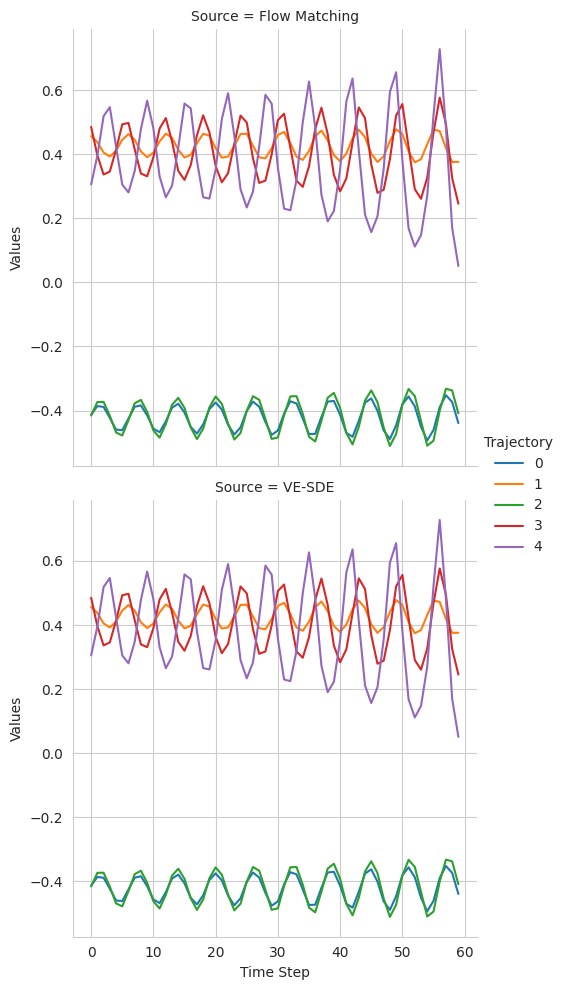

In [79]:
trajectory_count = 5
df = pd.concat([
    *itertools.chain.from_iterable([
        [
            pd.DataFrame(dict(
                Source=config_alt_ids[config_alt_id],
                Values=samples[constraint(samples) > 0][i, :, 0],
            ))
            for i in range(trajectory_count)
        ]
        for config_alt_id, info in cfg_info.items()
    ])
], axis=0, keys=len(cfg_info) * list(map(str, range(trajectory_count)))).reset_index(names=['Trajectory', 'Time Step'])
sns.relplot(
    kind='line',
    data=df,
    x='Time Step', y='Values',
    hue='Trajectory',
    row='Source',
)
print('Model-sampled events')

In [38]:
evaluation_trajectories = next(iter(dataloaders['val']))

Data


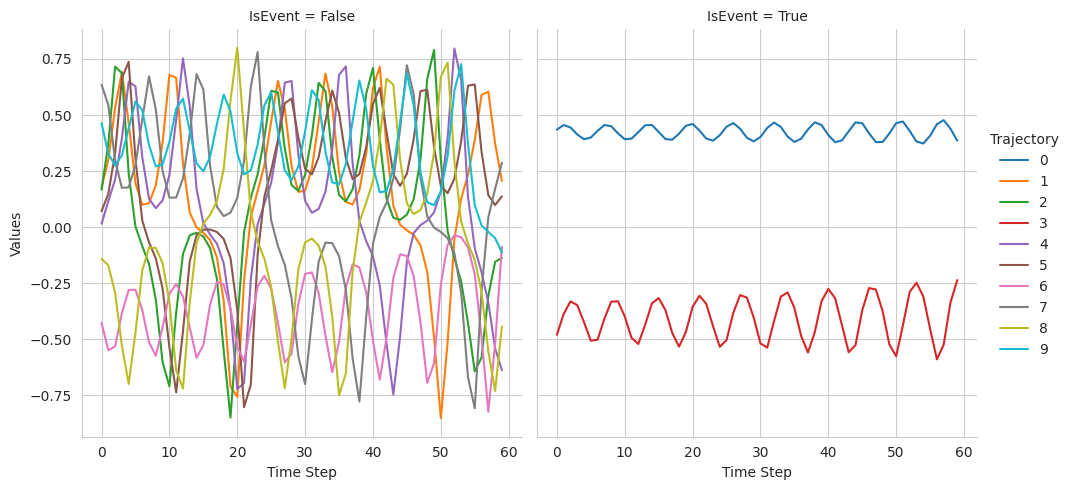

In [42]:
trajectory_count = 10
df = pd.concat([
    pd.DataFrame(dict(
        IsEvent=(constraint(evaluation_trajectories[i]) > 0).item(),
        Values=evaluation_trajectories[i, :, 0]
    )) for i in range(trajectory_count)
], axis=0, keys=map(str, range(trajectory_count))).reset_index(names=['Trajectory', 'Time Step'])
sns.relplot(
    kind='line',
    data=df,
    x='Time Step', y='Values',
    hue='Trajectory',
    col='IsEvent',
)
print('Data')

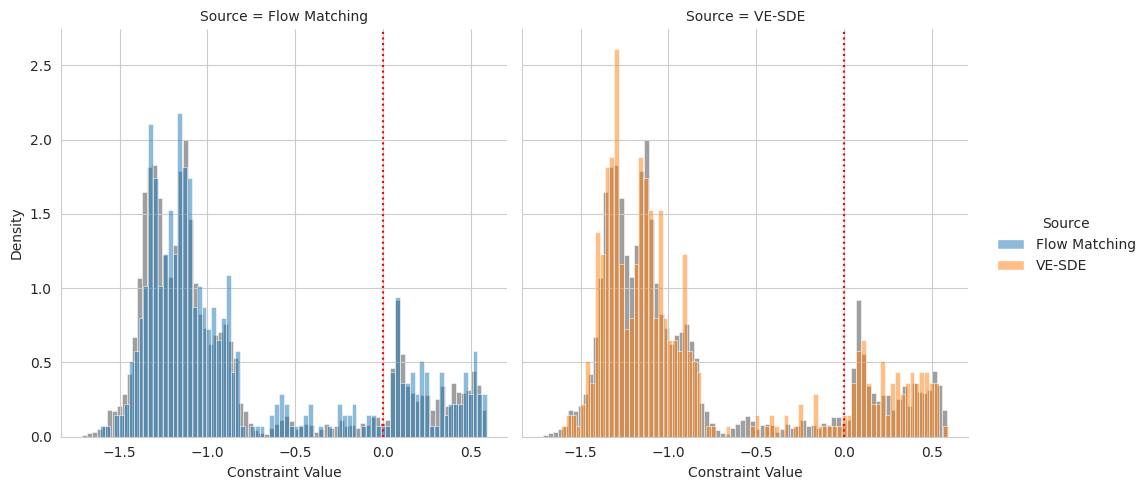

In [80]:
df = pd.concat([
    pd.Series(constraint(info['samples']), name=config_alt_ids[config_alt_id])
    for config_alt_id, info in cfg_info.items()
], axis=1).melt(var_name='Source', value_name='Constraint Value')
plot = sns.displot(
    data=df,
    stat='density',
    x='Constraint Value',
    col='Source',
    hue='Source',
    common_norm=False,
    bins=80,
)
plot.map(
    sns.histplot,
    data=pd.DataFrame({'Source': 'Data', 'Constraint Value': constraint(splits['train'])}),
    bins=80,
    stat='density',
    color='tab:grey',
    x='Constraint Value',
    zorder=-1,
)
for (row, col, hue), data in plot.facet_data():
    ax = plot.axes[row][col]
    ax.axvline(x=0, c='r', ls=':')

In [20]:
df = pd.concat((
    pd.Series(constraint(
        splits['train'][constraint(splits['train']) > 0]
    ), name='Data'),
    pd.Series(constraint(event_samples), name='Model-generated events'),
), axis=1).melt(var_name='Source', value_name='Constraint Value')
plot = sns.displot(
    data=df,
    stat='density',
    x='Constraint Value',
    hue='Source',
    common_norm=False,
    bins=80,
)
for (row, col, hue), data in plot.facet_data():
    ax = plot.axes[row][col]
    ax.axvline(x=0, c='r', ls=':')

NameError: name 'event_samples' is not defined